# Using custom, network-based graph

Very basic example using linear regression and a graph redived from travel cost.

In [2]:
import geodatasets
import geopandas as gpd
import osmnx as ox
import pandana
from libpysal.graph import Graph

from gwlearn.linear_model import GWLinearRegression


Get some data you want to model. This dataset is assumed to contain both dependent and independent variables.

In [3]:
df = gpd.read_file(geodatasets.get_path("geoda Cincinnati")).to_crs(4326)

Here I am getting nodes and edges forming a street network graph using OSMnx but this can be done in any way. Check pandana's documentation on how to construct a network.

In [4]:
osm_graph = ox.graph_from_polygon(df.union_all(), network_type="walk")
nodes, edges = ox.convert.graph_to_gdfs(osm_graph)
edges = edges.reset_index()

Generate a pandana network. All points will be linked to this network and accessibility will be measured alongside its edges.

In [5]:
network = pandana.Network(
    edge_from=edges["u"],
    edge_to=edges["v"],
    edge_weights=edges[["length"]],
    node_x=nodes["x"],
    node_y=nodes["y"],
)

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 6002
Setting CH edge vector of size 17056
Range graph removed 17488 edges of 34112
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


Use the network to build a graph with a set distance threshold and a kernel transforming the actual distance to a distance decay weight.

In [7]:
G = Graph.build_travel_cost(
    df.set_geometry(df.representative_point()), network, 1500, kernel="bisquare"
)

Check the properties of the resulting graph. You can see that on average, you have 129 neighbors.

In [8]:
G.summary()

Graph Summary Statistics
========================
Graph indexed by:
 [0, 1, 2, 3, 4, ...]
==============================================================
Number of nodes:                                           457
Number of edges:                                         59745
Number of connected components:                              1
Number of isolates:                                          0
Number of non-zero edges:                                59745
Percentage of non-zero edges:                           28.61%
Number of asymmetries:                            NA
--------------------------------------------------------------
Cardinalities
==============================================================
Mean:                     131    25%:                       79
Standard deviation:        60    50%:                      136
Min:                       12    75%:                      180
Max:                      238
--------------------------------------------------------------
Weights
==============================================================
Mean:                       0    25%:                        0
Standard deviation:         0    50%:                        0
Min:                        0    75%:                        1
Max:                        1
--------------------------------------------------------------
Sum of weights
==============================================================
S0:                                                      20114
S1:                                                      23553
S2:                                                    4500640
--------------------------------------------------------------
Traces
==============================================================
GG:                                                      11776
G'G:                                                     11776
G'G + GG:                                                23553

Fit the regression. 

In [9]:
gwlr = GWLinearRegression(
    graph=G, bandwidth=0   # need to pass graph. bandwidth is ignored but has to be specified now (will fix)
)
gwlr.fit(
    X=df[
        [
            "AGE_0_5",
            "AGE_5_9",
            "AGE_10_14",
            "AGE_15_19",
            "AGE_20_24",
            "AGE_25_34",
            "AGE_35_44",
            "AGE_45_54",
            "AGE_55_59",
            "AGE_60_64",
            "AGE_65_74",
            "AGE_75_84",
            "AGE_85",
        ]
    ],
    y=df["WHITE"],
)

AttributeError: 'NoneType' object has no attribute '_adjacency'

AttributeError: 'NoneType' object has no attribute '_adjacency'

GWLinearRegression(bandwidth=0,
                   graph=<Graph of 457 nodes and 59745 nonzero edges indexed by
 [0, 1, 2, 3, 4, ...]>)

Done. Now you can extract whatever the object contain. Like focal R2.

In [10]:
gwlr.focal_r2_

np.float64(0.9381192542606543)

Or local R2.

In [11]:
gwlr.local_r2_

0      0.833815
1      0.986429
2      0.988289
3      0.974424
4      0.983153
         ...   
452    0.795967
453    0.685935
454    0.708313
455    0.796146
456    0.853570
Length: 457, dtype: float64

That can be plotted.

<Axes: >

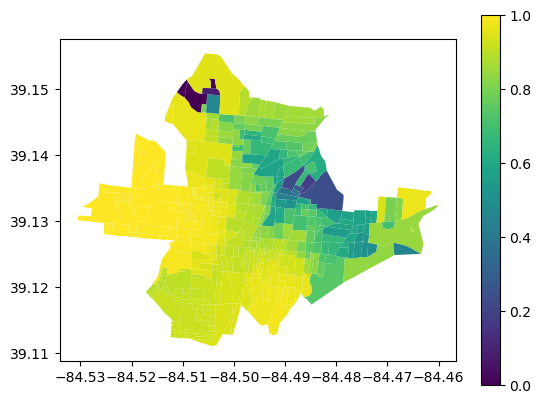

Exception ignored in: <function ResourceTracker.__del__ at 0x105c393a0>
Traceback (most recent call last):
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1070893a0>
Traceback (most recent call last):
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/m

In [12]:
df.plot(gwlr.local_r2_, legend=True, vmin=0, vmax=1)